# Visualize dataset

In [13]:
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from event_prediction.data.data_utils import download_data_from_url, extract

In [7]:

# url = "https://obj.umiacs.umd.edu/eventprediction/transactions_small.tgz"  # 1k transactions
# url = "https://obj.umiacs.umd.edu/eventprediction/transactions_med.tgz"  # 1m transactions
url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"  # 25m transactions
data = download_data_from_url(url)
print("Extracting...")
data = extract(data)
print("Creating dataframe...")
df = pd.read_csv(data)

print(f"Total rows: {df.shape[0]}, total columns: {df.shape[1]}")
df.head()

Total rows: 24386900, total columns: 15


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


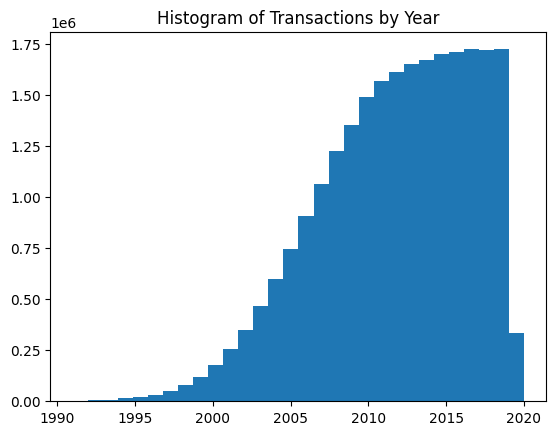

In [9]:
plt.hist(df['Year'], bins=len(df['Year'].unique()))
plt.title('Histogram of Transactions by Year')
plt.show()

In [14]:
# Optionally save a subset of the dataset if you wish.

# df.head(int(1e6)).to_csv('temp.csv', index=False)
# with tarfile.open('transactions_med.tgz', 'w:gz') as f:
#     f.add('temp.csv')

    